In [1]:
# Import Libraries
import pandas as pd  # Data Reading
import seaborn as sb  # Advanced Data Visualization
import matplotlib.pyplot as mplot  # Data Visualization

In [2]:
# Input Matrix Files
matrices = ["matrix1", "matrix2"]
input_folder = "data/"
output_folder = "output/"

In [3]:
def correlation_matrix(matrix_name: str, digits=3) -> dict:
    # Function Returns a Correlation Matrix from a Txt File

    def read_matrix(folder: str, file_name: str, extension: str):
        # Function Reads the Matrix and Returns it as a Pandas DF
        extension = "." + extension.lower()
        file_path = folder + file_name + extension
        matrix_df = pd.read_csv(file_path, sep='\t')

        return matrix_df

    # Obtain the DF from the Matrix.txt
    data = read_matrix(input_folder, matrix_name, "txt")

    # Drop the Extra Column Produced by Extraneous Delimiters
    data = data.drop(columns=['Unnamed: 13'])
    # print(data)

    # Excluding the non-numeric column (assuming it's the first column)
    numeric_data = data.select_dtypes(include=[float, int])

    # Generate the Correlation Matrix
    correlation_matrix = numeric_data.corr()

    # Return the Dictionary
    return {"name": matrix_name, "matrix": correlation_matrix.round(decimals=digits)}

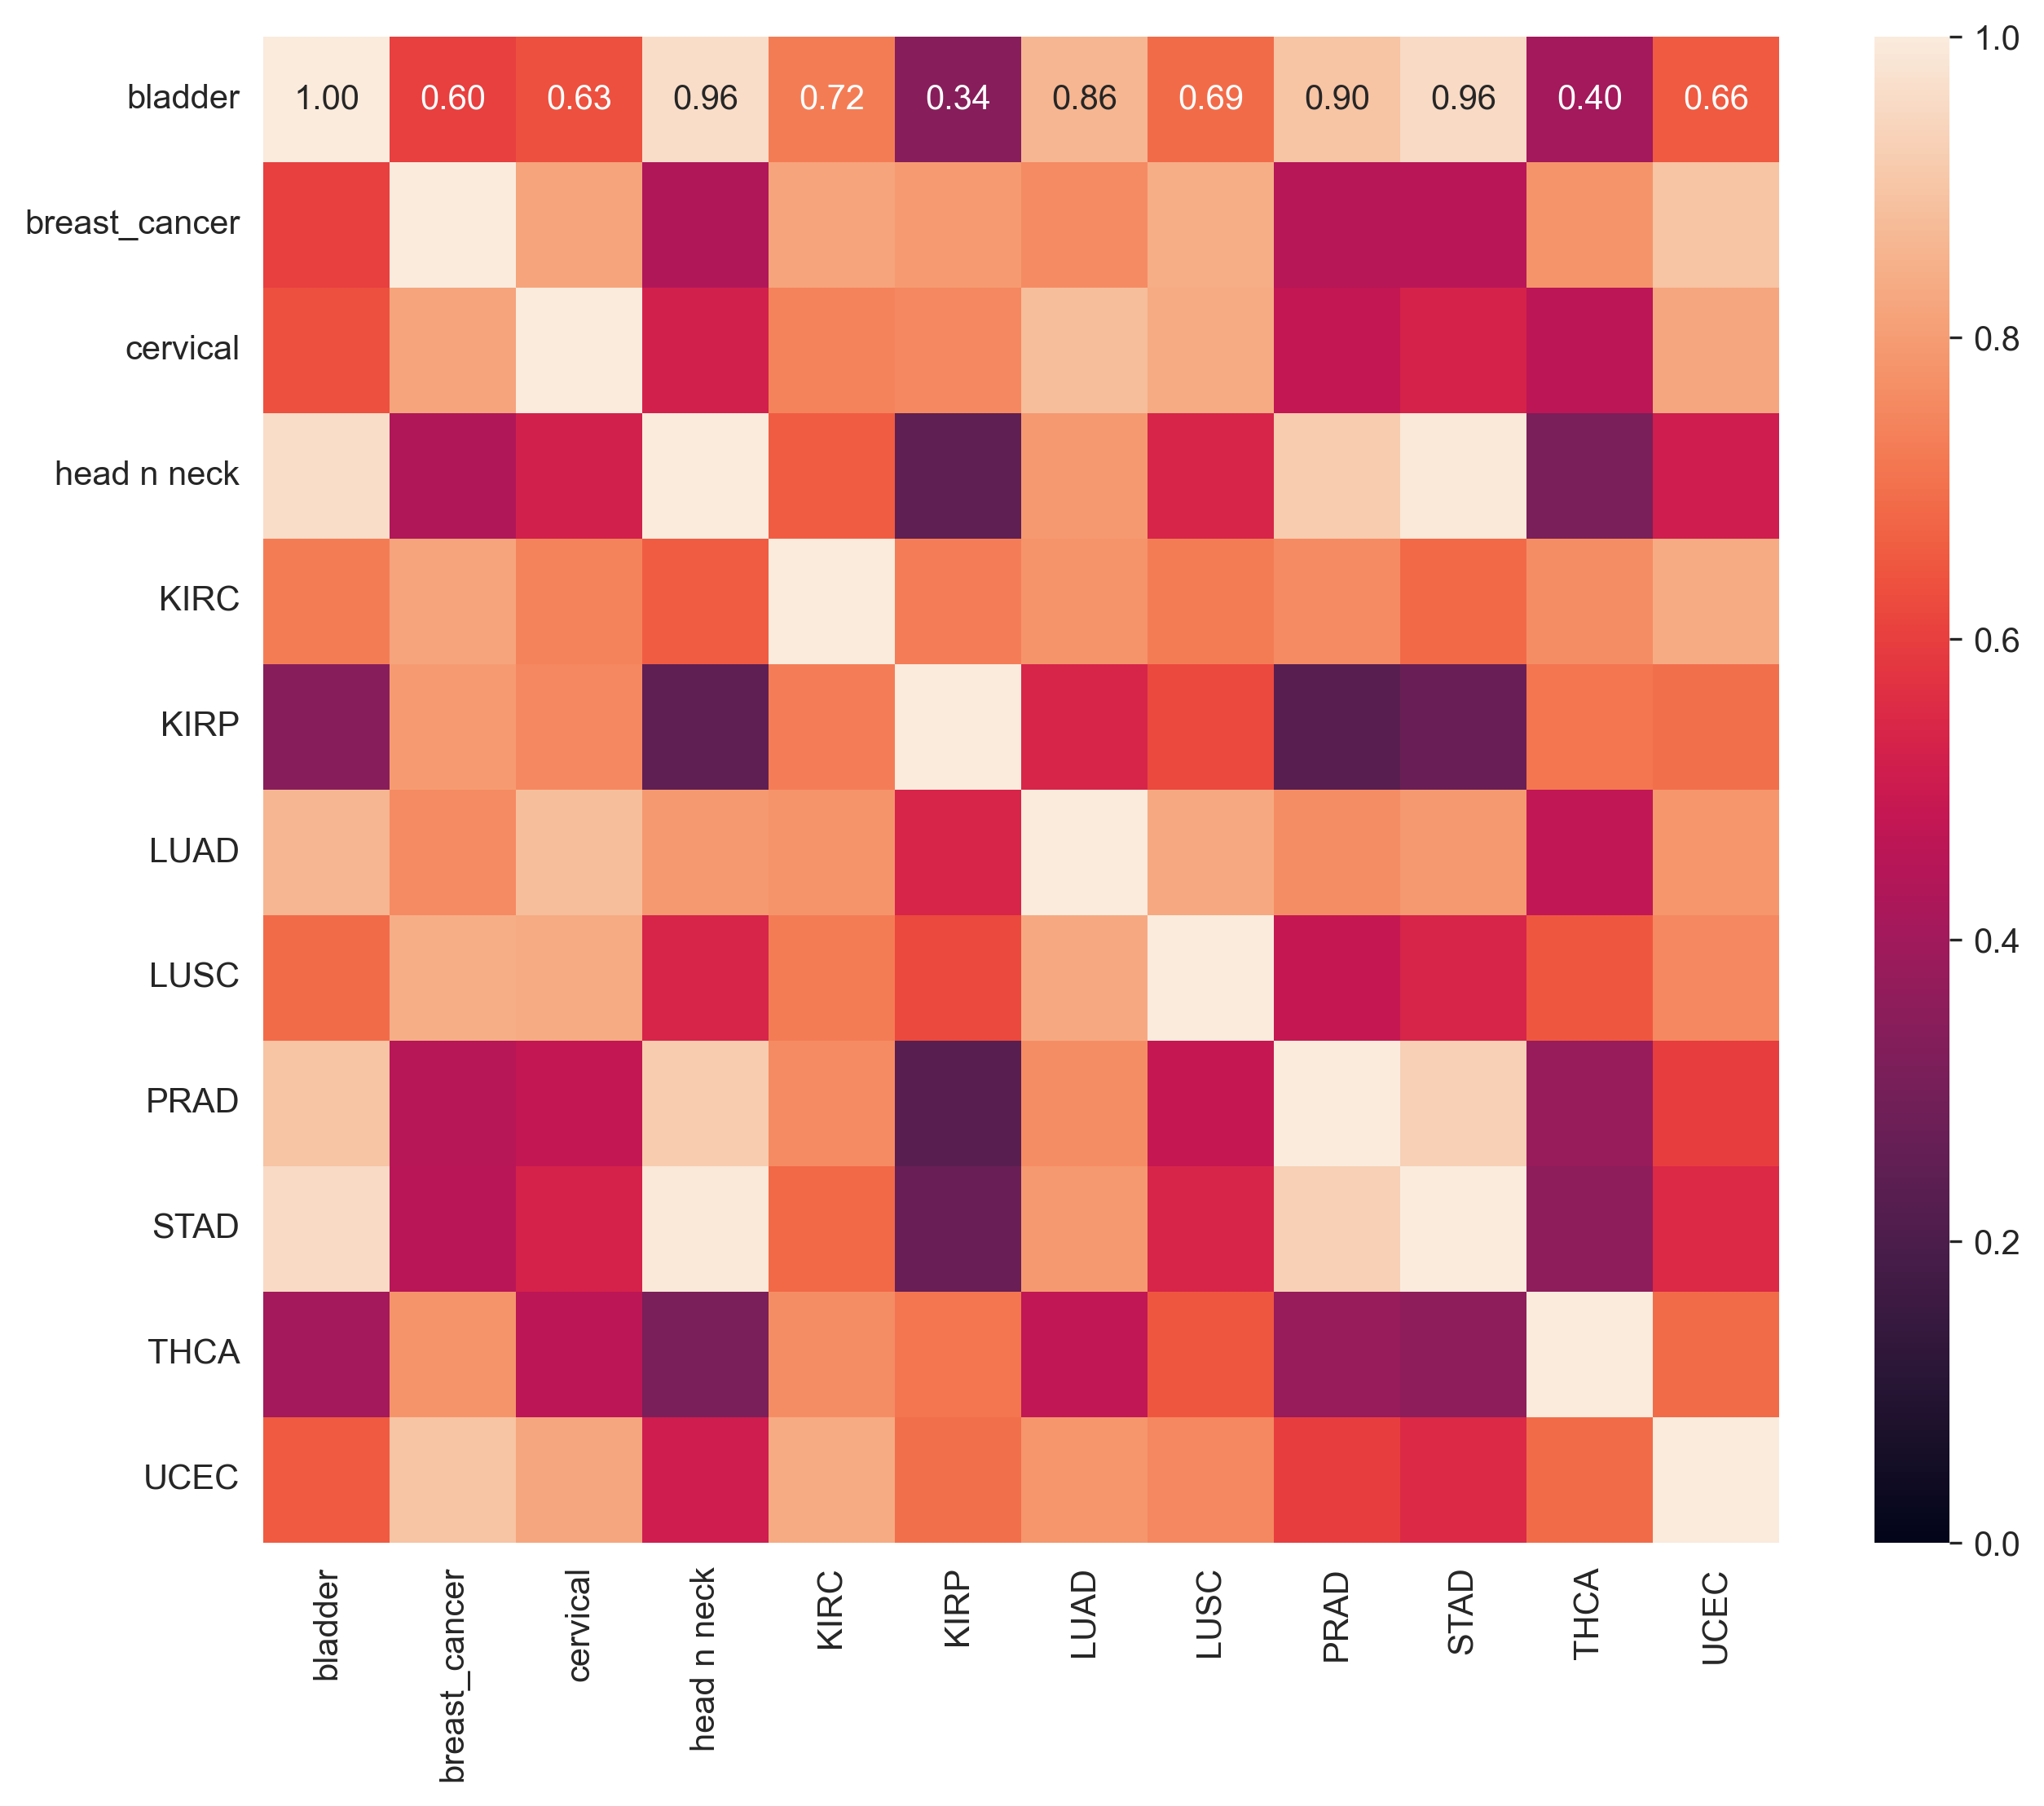

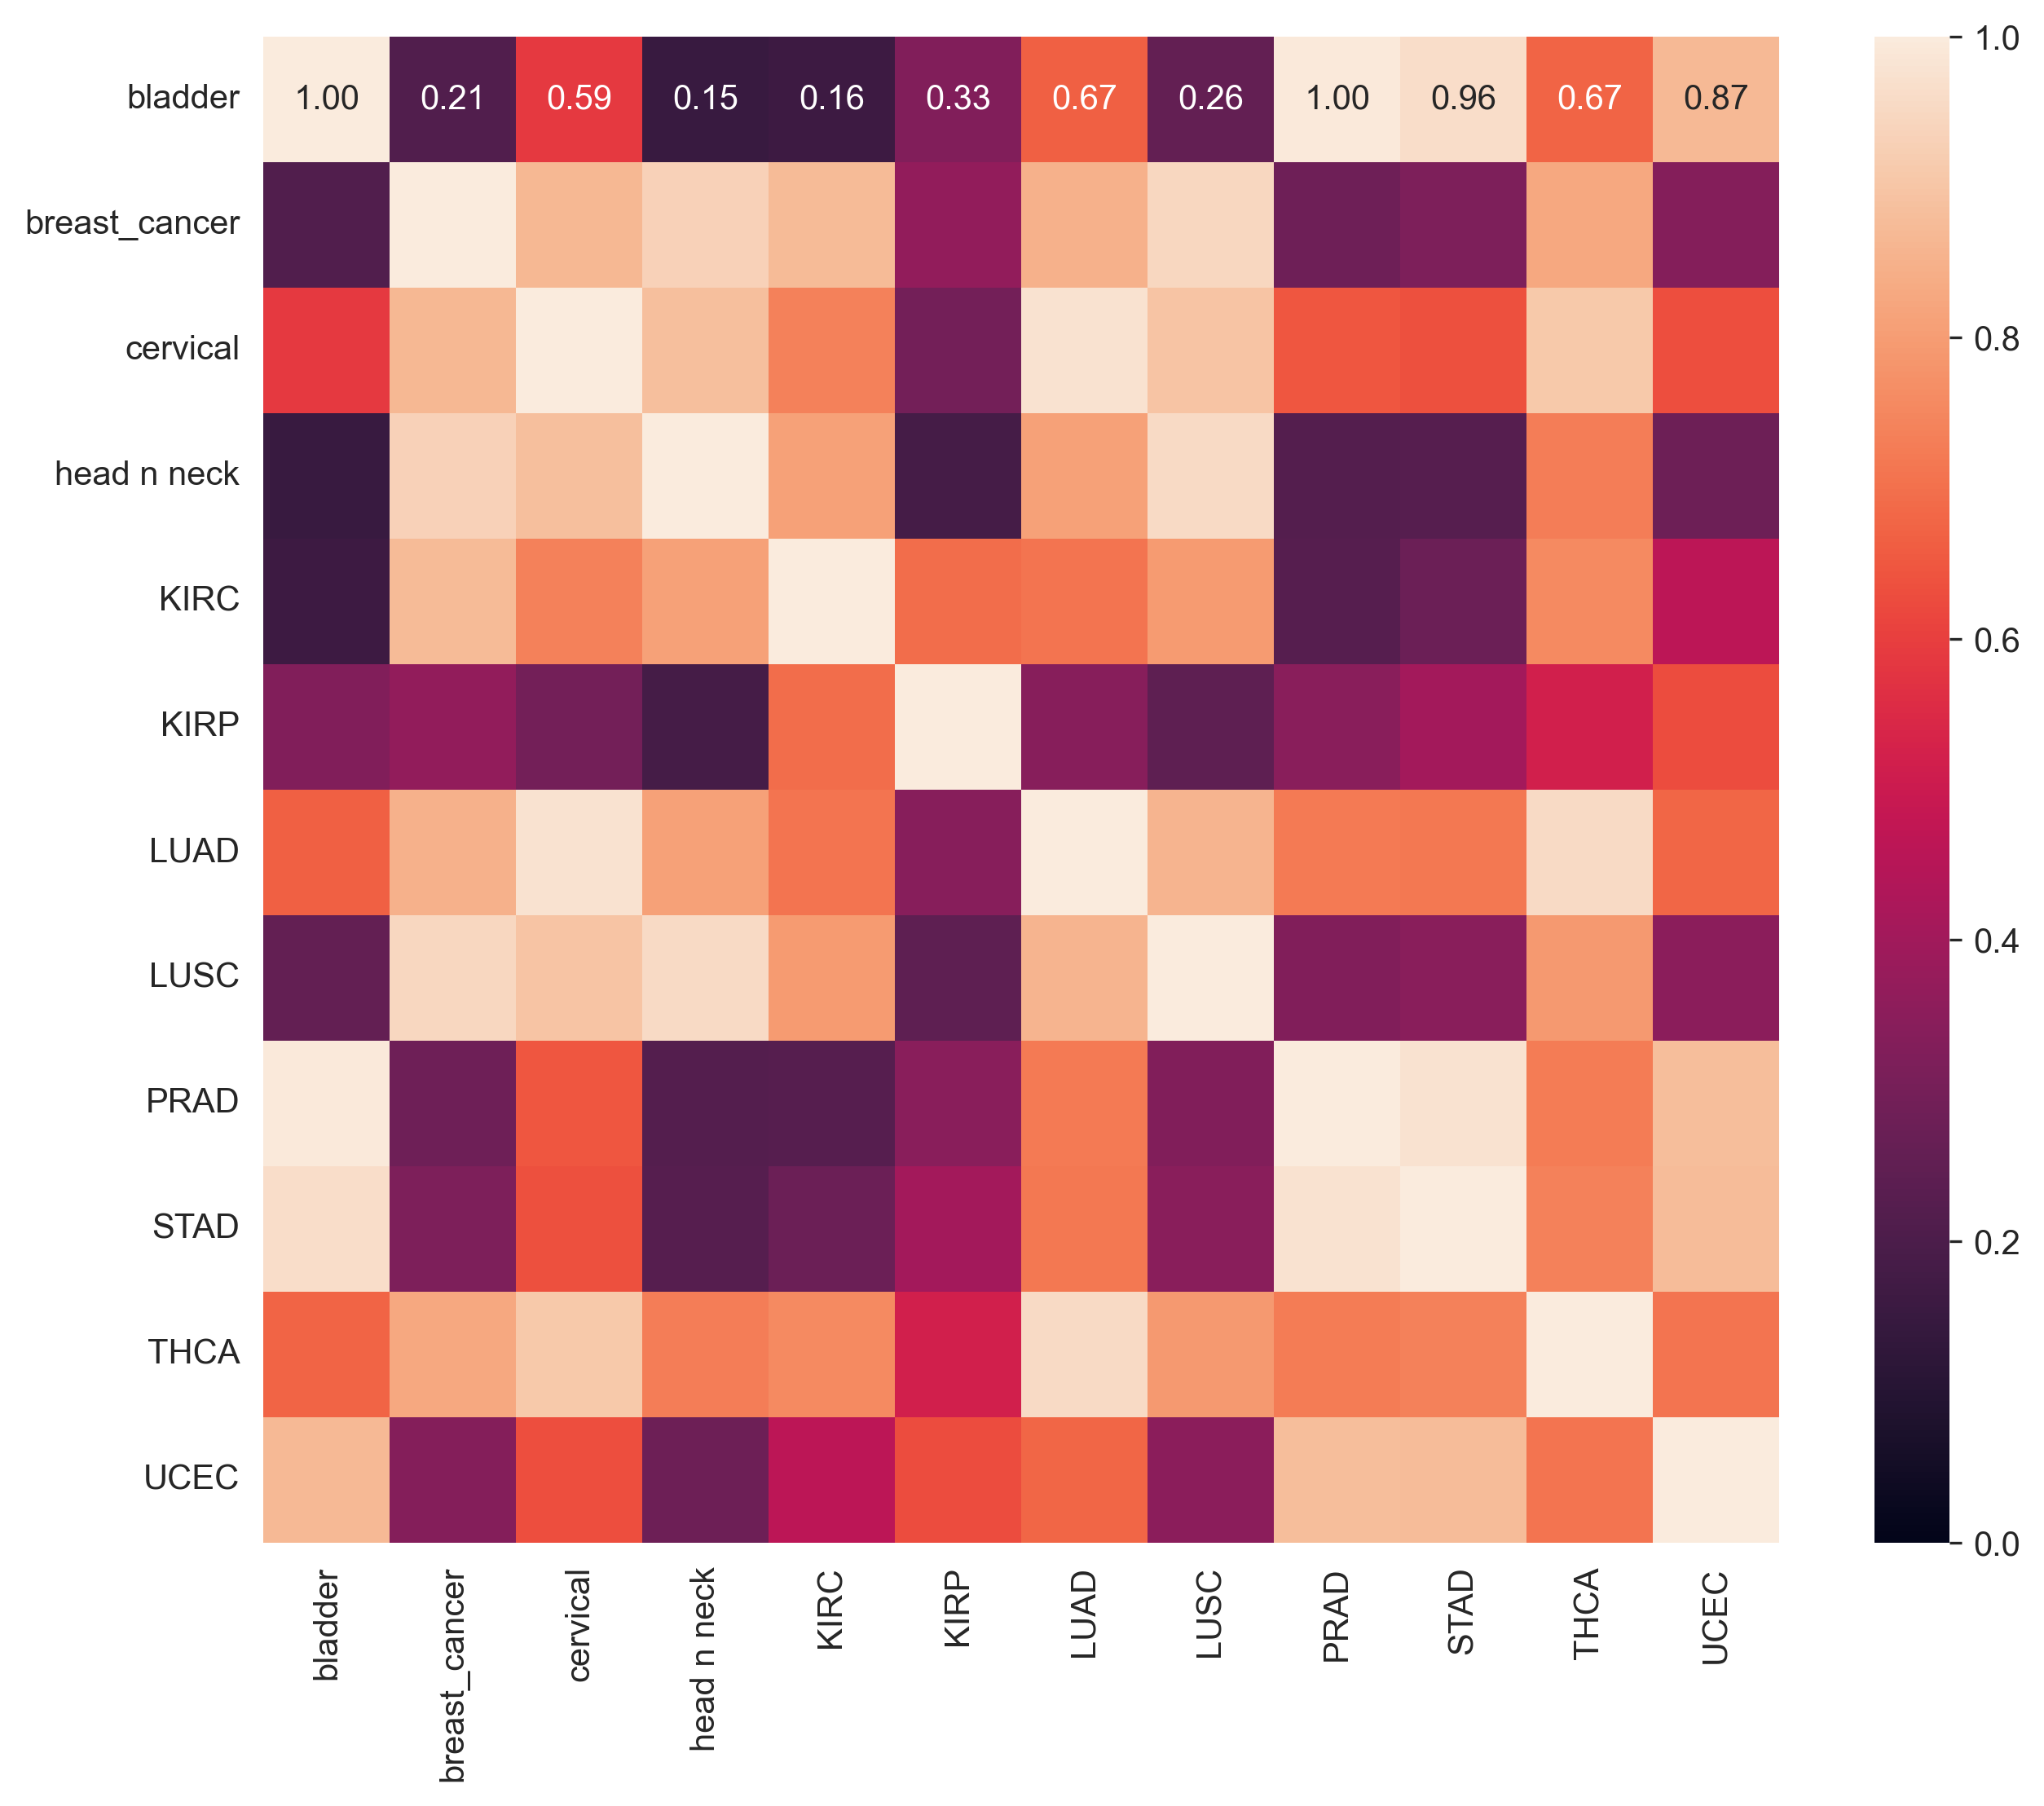

In [4]:
# Temporary List of Dictionaries in the format [{ name: val, matrix: val }, {...}]
correlation_matrices = []

# Generate Correlation Matrices for Each Matrix File
for matrix in matrices:
    correlation_matrices.append(correlation_matrix(matrix))

# Gene
for correlation_matrix_dict in correlation_matrices:

    # Heatmap Plot
    mplot.figure(figsize=(10, 8), dpi=300)
    sb.heatmap(correlation_matrix_dict["matrix"], annot=True, fmt=".2f", cmap="rocket", vmin=0, vmax=1)

    # Path to the Output File
    output_file_path = output_folder + correlation_matrix_dict["name"] + "_heatmap.png"

    # Save the Figure
    mplot.savefig(output_file_path, dpi=300, bbox_inches='tight', transparent=True)